# Régression logistique

In [1]:
import json
import time

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

from tools import (COLUMNS_CAT, COLUMNS_QUANT, Modelisation, SearchCV,
                   best_score_CV, datasets, graph_2scores_CV,
                   graph_2scores_CV_comp, graph_3scores_CV, graph_param_CV,
                   restauration_CV, PDF)

## Matplotlib : 
# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
# %config InlineBackend.figure_format = 'png'

pdf = PDF('output/model_LR/')

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df, drop='first')
X_quant = datasets_df['X_quant_scaled']
X_cat = datasets_df['X_cat']
X = datasets_df['X_only_quant_scaled']
y = datasets_df['y']

Columns_quant : default
Columns_cat : default
drop : first

Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

## 1. Modèle brut
### 1.1. Variables quantitatives

Export PDF : output/model_LR/00.pdf



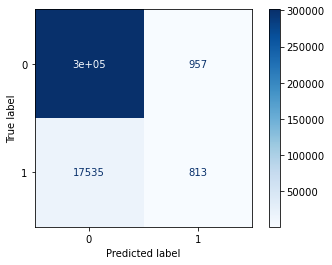

f1 : 0.0808
f3 : 0.0487
f5 : 0.0459
recall : 0.0443
negative predictive value : 0.9450
precision : 0.4593
roc_auc : 0.7376
training time : 2.036s
prediction time : 0.017s


In [4]:
m = Modelisation(X_quant, y, LogisticRegression())
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

Export PDF : output/model_LR/01.pdf



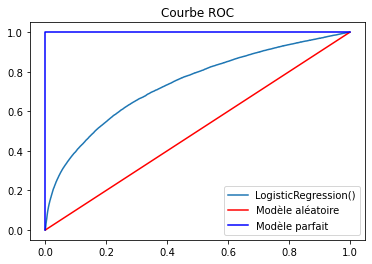

In [5]:
m.show_ROC(pdf=pdf)

In [6]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X_quant.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.027268
campaignctrlast24h,0.360537
dayssincelastvisitdouble,-0.024851
ltf_nbglobaldisplay_4w,0.013629
ltf_nbpartnerdisplayssincelastclick,-0.021464
ltf_nbpartnerdisplay_90d,-0.016561
ltf_nbpartnerclick_90d,0.035113
ltf_nbpartnersales_90d,-0.009656
nbdayssincelastclick,-0.111813
nbdisplay_1hour,-0.225264


In [7]:
X_ = add_constant(X_quant)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197291
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1603554
Model:                          Logit   Df Residuals:                  1603540
Method:                           MLE   Df Model:                           13
Date:                Tue, 30 Mar 2021   Pseudo R-squ.:                 0.09816
Time:                        08:40:53   Log-Likelihood:            -3.1637e+05
converged:                       True   LL-Null:                   -3.5080e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.0392      0.0

### 1.2. Variables catégorielles

In [8]:
# Nombre de valeurs distinctes
for column in COLUMNS_CAT:
    print(f"{column} : {df[column].nunique()}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 5
is_interstitial : 2
device_type : 7
hour : 24
weekday : 7


Export PDF : output/model_LR/02.pdf



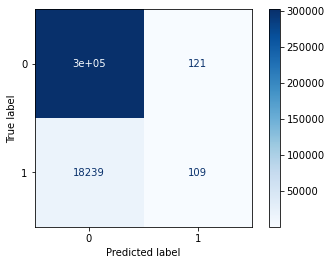

f1 : 0.0117
f3 : 0.0066
f5 : 0.0062
recall : 0.0059
negative predictive value : 0.9431
precision : 0.4739
roc_auc : 0.6882
training time : 15.527s
prediction time : 0.066s


In [9]:
m = Modelisation(X_cat, y, LogisticRegression())
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

### 1.3. Variables quantitatives + catégorielles

Export PDF : output/model_LR/03.pdf



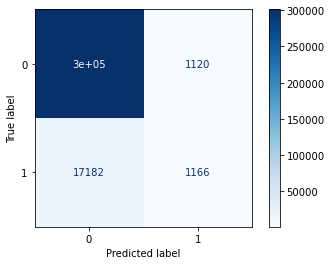

f1 : 0.1130
f3 : 0.0696
f5 : 0.0658
recall : 0.0635
negative predictive value : 0.9460
precision : 0.5101
roc_auc : 0.7552
training time : 12.966s
prediction time : 0.093s


In [10]:
m = Modelisation(X, y, LogisticRegression())
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

Export PDF : output/model_LR/04.pdf



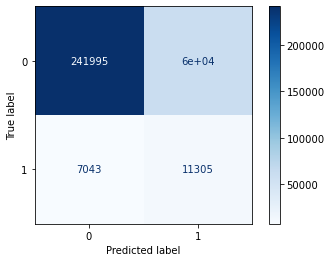

f1 : 0.2512
f3 : 0.4774
f5 : 0.5542
recall : 0.6161
negative predictive value : 0.9717
precision : 0.1577
roc_auc : 0.7763
training time : 8.866s
prediction time : 0.059s


In [11]:
m = Modelisation(X, y, LogisticRegression(class_weight='balanced'))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

## 2. Tuning des hyperparamètres avec GridSearchCV

In [12]:
model = LogisticRegression()

cv_params = {
    "C": np.logspace(-6, 2, 30),
    "class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8},
                     {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18},
                     {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28},
                     {0:1, 1:30}, {0:1, 1:32}]
}

print(len(ParameterGrid(cv_params)))

540


In [13]:
# SearchCV(model, cv_params, data_frac=1, drop='first', scaling=True, sparse=True, n_jobs=28)

In [14]:
dico, results = restauration_CV('LR_CV_Grid_540_1')

model : LogisticRegression()
model_name : LR
type : GridSearchCV
len_grid : 540
columns_quant : default
columns_cat : default
drop : first
data_frac : 1
n_jobs : 28
temps : 50min, 55.649s
params : {'C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0: 1, 1: 8}, {0: 1, 1: 10}, {0: 1, 1: 12}, {0: 1, 1: 14}, {0: 1, 1: 16}, {0: 1, 1: 18}, {0: 1, 1: 20}, {0: 1, 1: 22}, {0: 1, 1: 24}, {0: 1, 1: 26}, {0: 1, 1: 28}, {0: 1, 1: 30}, {0:

Export PDF : output/model_LR/05.pdf



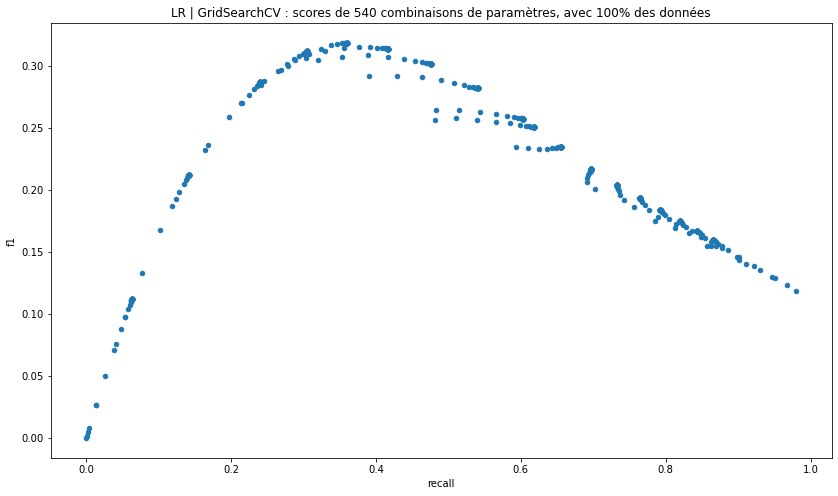

In [15]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20, pdf=pdf)

Export PDF : output/model_LR/06.pdf



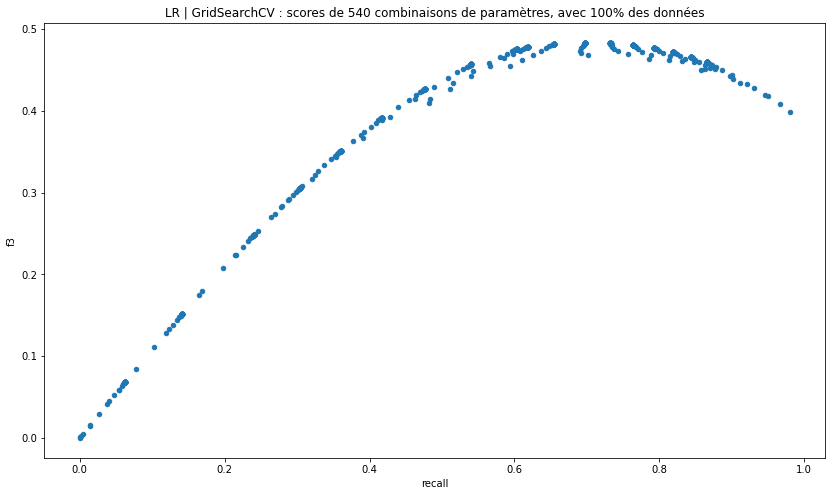

In [16]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=20, pdf=pdf)

Export PDF : output/model_LR/07.pdf



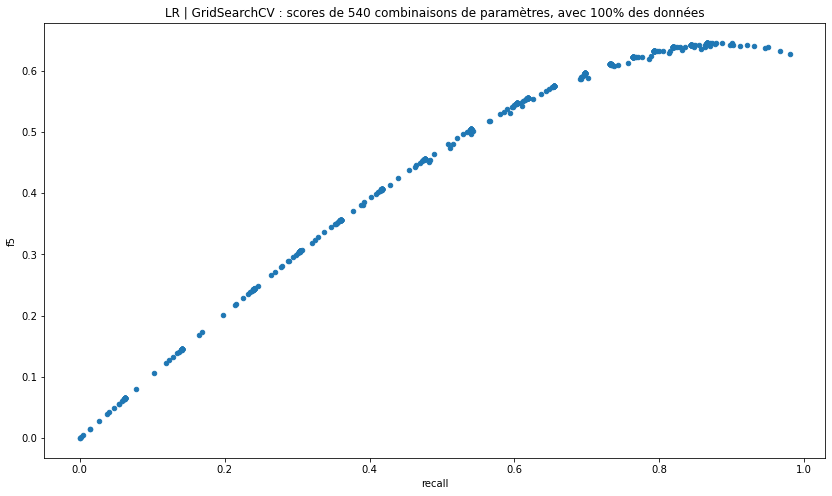

In [17]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=20, pdf=pdf)

Export PDF : output/model_LR/08.pdf



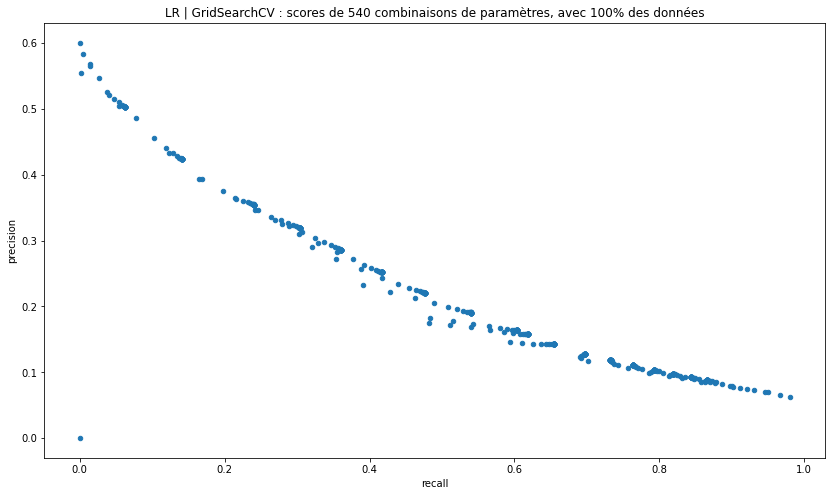

In [18]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=20, pdf=pdf)

Export PDF : output/model_LR/09.pdf



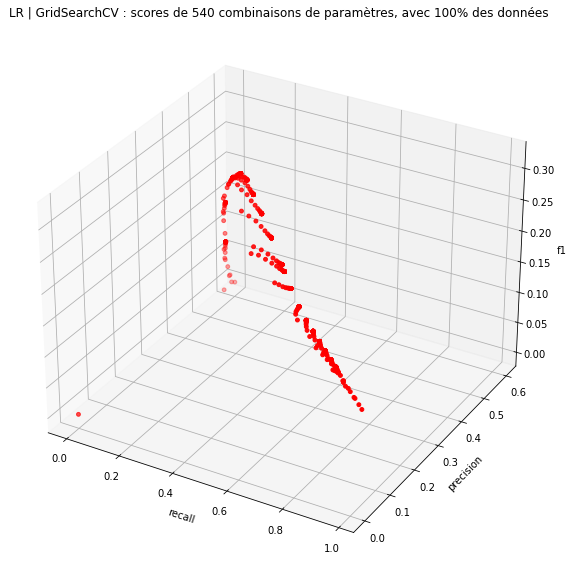

In [19]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=15, pdf=pdf)

Export PDF : output/model_LR/10.pdf



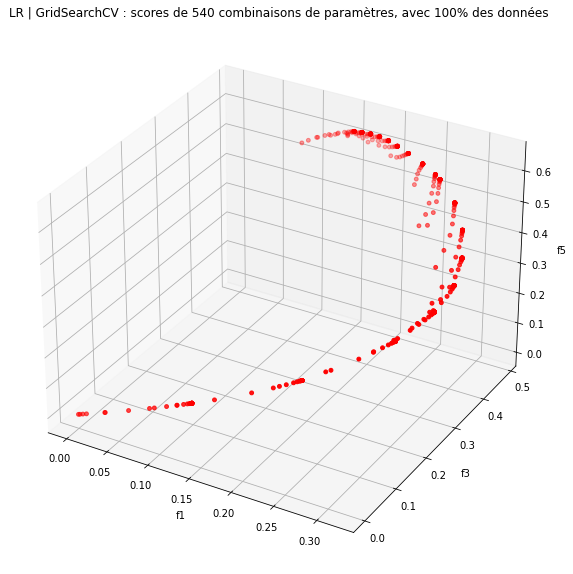

In [20]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=15, pdf=pdf)

Export PDF : output/model_LR/11.pdf



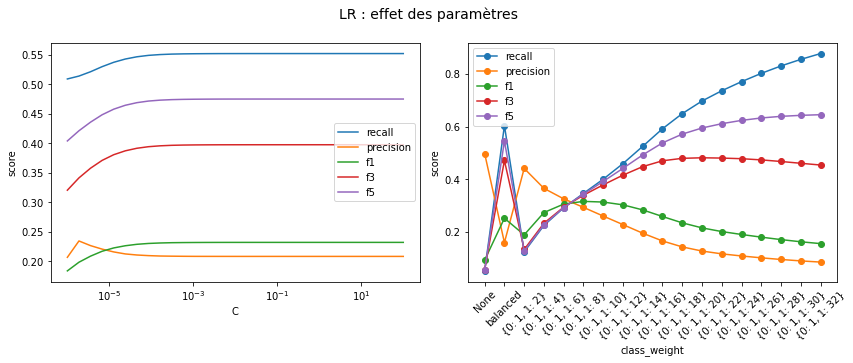

In [21]:
graph_param_CV(dico, results, xscale={'C': 'log'}, ncols=2, height=5, width=6, pdf=pdf)

In [22]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,mean_test_recall,std_test_recall,rank_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
335,32.876679,7.694967,1.786899,0.429386,0.092367,"{0: 1, 1: 20}","{'C': 0.09236708571873865, 'class_weight': {0:...",0.697425,0.001878,184,...,331,0.216664,0.000481,270,0.483052,0.001073,1,0.595739,0.001447,183
317,29.726963,6.354735,1.948832,0.036545,0.048939,"{0: 1, 1: 20}","{'C': 0.04893900918477489, 'class_weight': {0:...",0.697425,0.001878,184,...,332,0.216662,0.000483,271,0.483051,0.001083,2,0.595738,0.001454,184
371,34.353554,2.6113,1.925609,0.151485,0.329034,"{0: 1, 1: 20}","{'C': 0.3290344562312671, 'class_weight': {0: ...",0.697435,0.001872,182,...,333,0.216658,0.00048,272,0.483051,0.001074,3,0.595743,0.001445,181
263,35.351695,3.210402,1.865547,0.345596,0.007279,"{0: 1, 1: 20}","{'C': 0.007278953843983146, 'class_weight': {0...",0.697414,0.001868,194,...,330,0.216665,0.000478,269,0.483049,0.001065,4,0.595733,0.001437,190
299,34.396108,2.28924,1.980011,0.079596,0.025929,"{0: 1, 1: 20}","{'C': 0.02592943797404667, 'class_weight': {0:...",0.697435,0.001872,182,...,337,0.216655,0.000495,276,0.483047,0.001079,5,0.595741,0.001445,182
353,34.824948,1.186395,1.85103,0.307488,0.174333,"{0: 1, 1: 20}","{'C': 0.17433288221999874, 'class_weight': {0:...",0.697425,0.001878,184,...,334,0.216657,0.000479,273,0.483046,0.001075,6,0.595735,0.001448,185
281,34.119181,3.399326,1.977067,0.135132,0.013738,"{0: 1, 1: 20}","{'C': 0.013738237958832637, 'class_weight': {0...",0.697425,0.001878,184,...,336,0.216655,0.000486,274,0.483043,0.001074,7,0.595734,0.001446,186
533,37.095176,3.989224,1.632034,0.353375,100.0,"{0: 1, 1: 20}","{'C': 100.0, 'class_weight': {0: 1, 1: 20}}",0.697425,0.001878,184,...,338,0.216653,0.000478,277,0.483041,0.001072,8,0.595733,0.001446,187
515,33.525161,2.898188,1.994065,0.091881,52.983169,"{0: 1, 1: 20}","{'C': 52.98316906283702, 'class_weight': {0: 1...",0.697425,0.001878,184,...,338,0.216653,0.000478,277,0.483041,0.001072,8,0.595733,0.001446,187
497,35.740926,3.591368,1.960043,0.283519,28.072162,"{0: 1, 1: 20}","{'C': 28.072162039411758, 'class_weight': {0: ...",0.697425,0.001878,184,...,338,0.216653,0.000478,277,0.483041,0.001072,8,0.595733,0.001446,187


Meilleure combinaison de paramètres pour f3 :


{'C': 0.09236708571873865, 'class_weight': {0: 1, 1: 20}}

In [23]:
PARAMS = {}
PARAMS[dico['model_name']] = best_params

Export PDF : output/model_LR/12.pdf



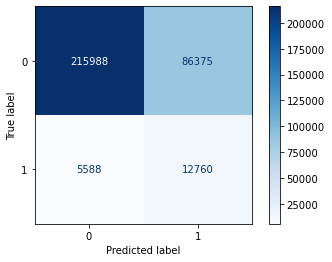

f1 : 0.2172
f3 : 0.4828
f5 : 0.5947
recall : 0.6954
negative predictive value : 0.9748
precision : 0.1287
roc_auc : 0.7773
training time : 9.921s
prediction time : 0.065s


In [24]:
m = Modelisation(X, y, LogisticRegression(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

SCORES = []
metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

## 3. Régression logistique avec oversampling

In [25]:
len(y[y == 1]) / (len(y[y == 0]))

0.06049828183239467

In [26]:
df_small = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.05)
df_small.shape

(80525, 48)

In [27]:
datasets_df_small = datasets(df_small, verbose=False, drop='first')
X_small = datasets_df_small['X_only_quant_scaled']
y_small = datasets_df_small['y']

In [28]:
categorical_features = list(range(len(COLUMNS_QUANT), len(X.columns)))
print(categorical_features)

over = SMOTENC(categorical_features=categorical_features,
               sampling_strategy=1,
               k_neighbors=5,
               random_state=1234,
               n_jobs=-1)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


Export PDF : output/model_LR/13.pdf



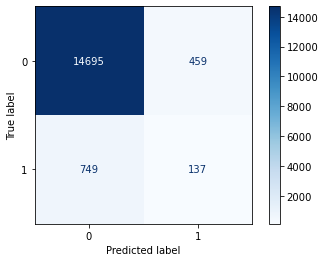

f1 : 0.1849
f3 : 0.1599
f5 : 0.1566
recall : 0.1546
negative predictive value : 0.9515
precision : 0.2299
roc_auc : 0.7017
training time : 58.101s
prediction time : 0.009s


In [29]:
m = Modelisation(X_small, y_small, pipeline)
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

In [30]:
over = RandomOverSampler(sampling_strategy=1, random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

Export PDF : output/model_LR/14.pdf



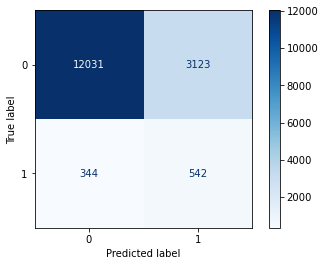

f1 : 0.2382
f3 : 0.4657
f5 : 0.5459
recall : 0.6117
negative predictive value : 0.9722
precision : 0.1479
roc_auc : 0.7795
training time : 1.373s
prediction time : 0.012s


In [31]:
m = Modelisation(X_small, y_small, pipeline)
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

### 3.1. GridSearchCV avec RandomOverSampler

In [32]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

cv_params = {
    "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    "model__C": np.logspace(-6, 2, 30),
    "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                            {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                            {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                            {0:1, 1:30}, {0:1, 1:32}]
}

print(len(ParameterGrid(cv_params)))

3240


In [33]:
# SearchCV(pipeline, cv_params, data_frac=1, drop='first', scaling=True, sparse=True, n_jobs=28)

In [34]:
dico, results = restauration_CV('RandomOver_LR_CV_Grid_3240_1')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', LogisticRegression())])
model_name : RandomOver_LR
type : GridSearchCV
len_grid : 3240
columns_quant : default
columns_cat : default
drop : first
data_frac : 1
n_jobs : 28
temps : 5h, 47min, 59.431s
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'model__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0

Export PDF : output/model_LR/15.pdf



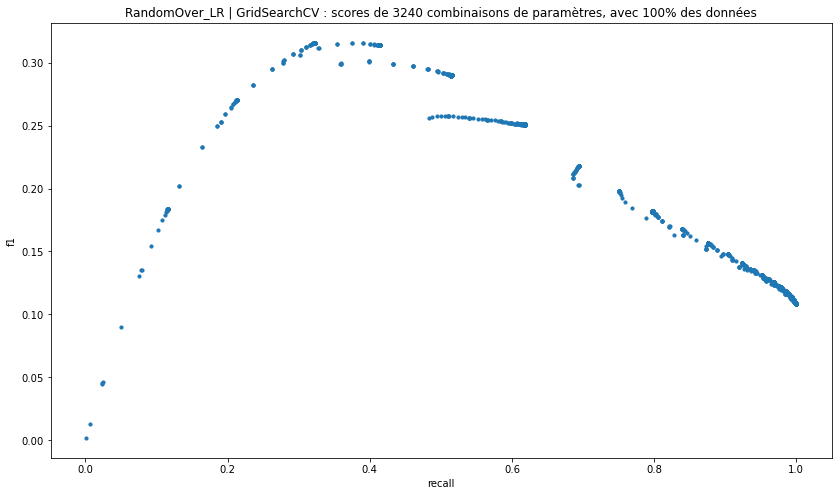

In [35]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=10, pdf=pdf)

Export PDF : output/model_LR/16.pdf



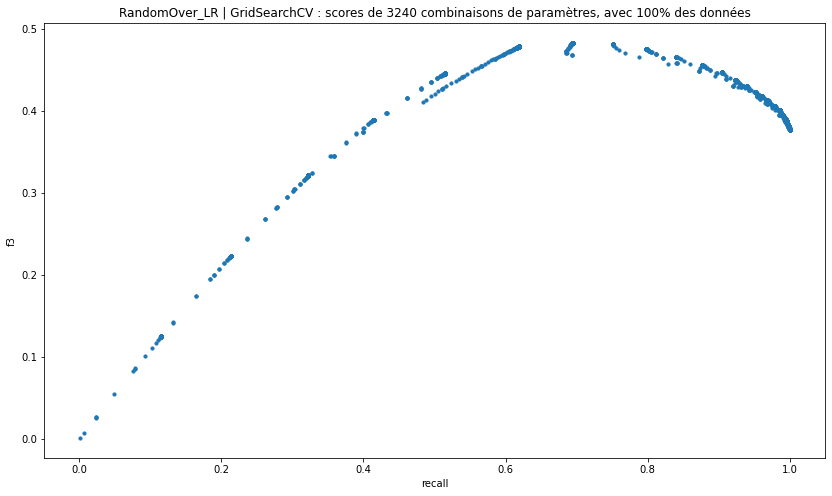

In [36]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=10, pdf=pdf)

Export PDF : output/model_LR/17.pdf



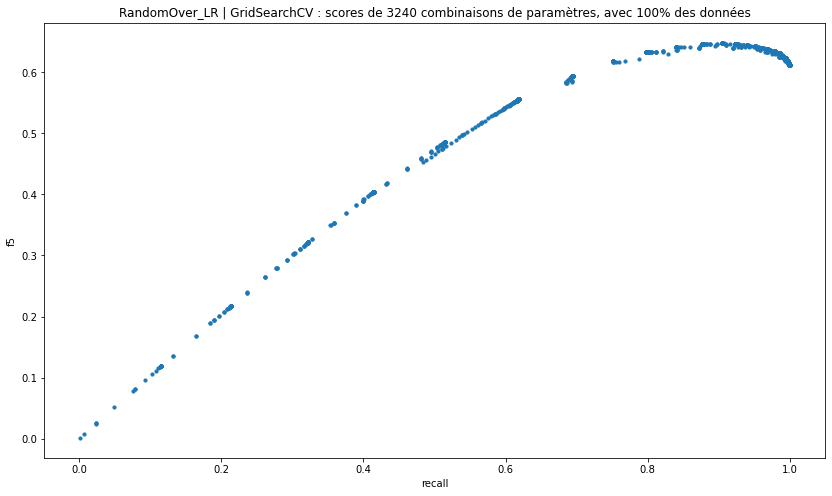

In [37]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=10, pdf=pdf)

Export PDF : output/model_LR/18.pdf



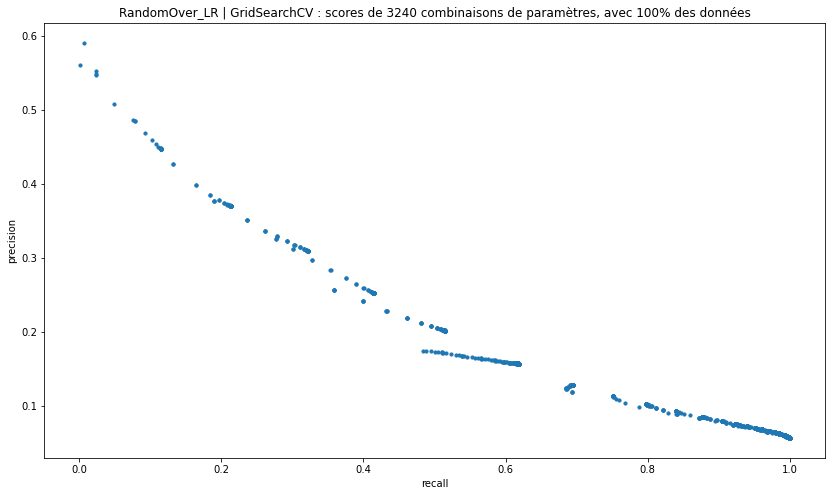

In [38]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=10, pdf=pdf)

Export PDF : output/model_LR/19.pdf



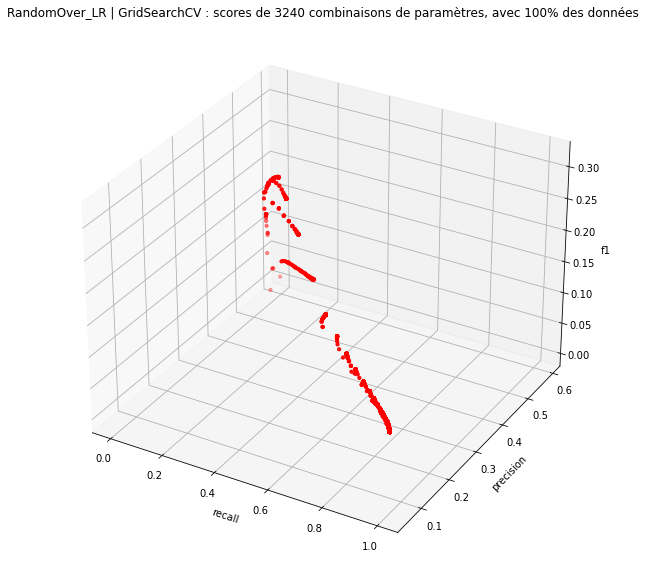

In [39]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=10, pdf=pdf)

Export PDF : output/model_LR/20.pdf



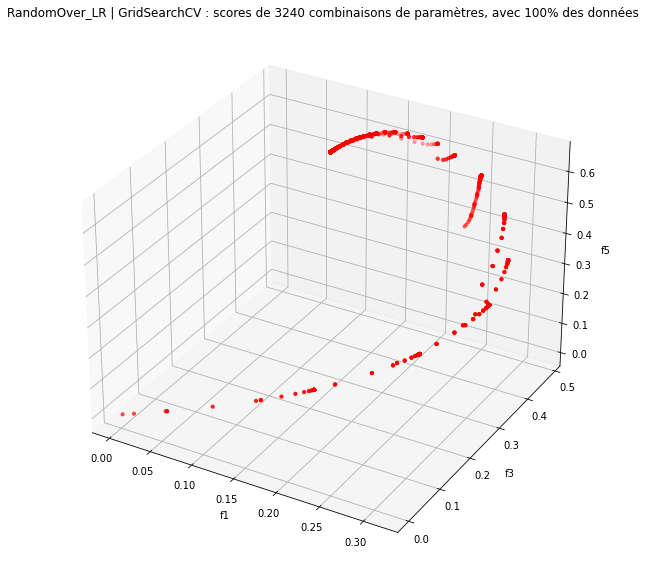

In [40]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=10, pdf=pdf)

Export PDF : output/model_LR/21.pdf



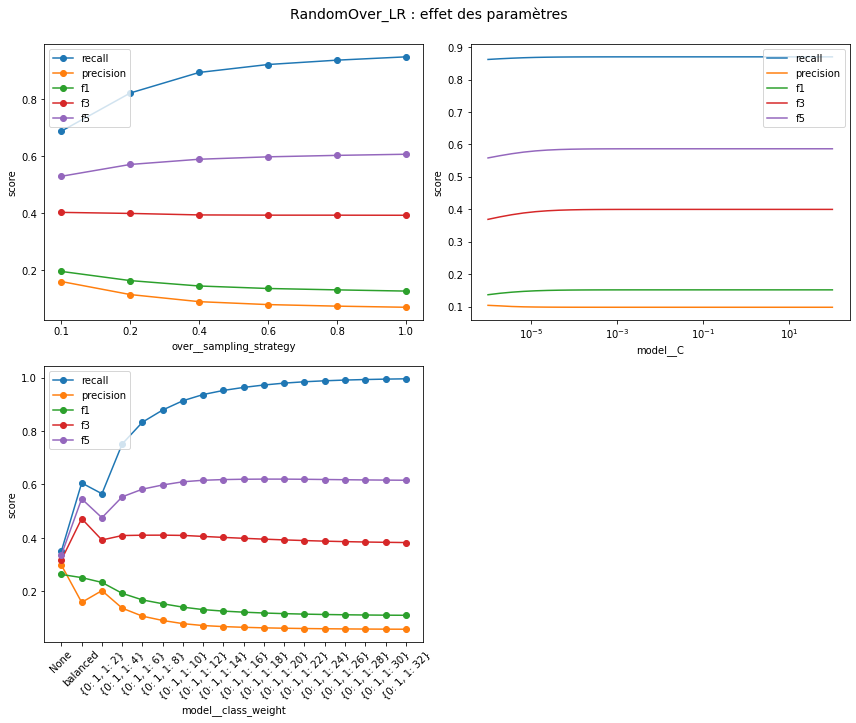

In [41]:
graph_param_CV(dico, results, xscale={'model__C': 'log'}, ncols=2, height=5, width=6, pdf=pdf)

In [42]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_over__sampling_strategy,params,mean_test_recall,std_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
2509,37.742544,2.115573,1.763205,0.197262,2.212216,"{0: 1, 1: 6}",0.2,"{'model__C': 2.21221629107045, 'model__class_w...",0.694473,0.002291,...,625,0.217838,0.001102,589,0.483076,0.001939,1,0.594425,0.002152,2551
2833,38.624121,1.832793,1.886724,0.087812,14.873521,"{0: 1, 1: 6}",0.2,"{'model__C': 14.873521072935118, 'model__class...",0.694462,0.0023,...,621,0.217841,0.001101,583,0.483074,0.001943,2,0.594419,0.002159,2552
2725,38.215983,2.107655,1.698178,0.434057,7.880463,"{0: 1, 1: 6}",0.2,"{'model__C': 7.880462815669905, 'model__class_...",0.694462,0.002281,...,622,0.21784,0.001102,585,0.483073,0.001936,3,0.594419,0.002145,2553
3157,36.154528,4.057517,1.661433,0.239251,100.0,"{0: 1, 1: 6}",0.2,"{'model__C': 100.0, 'model__class_weight': {0:...",0.694462,0.0023,...,624,0.217839,0.0011,586,0.483073,0.001941,4,0.594418,0.002157,2554
3049,38.998769,2.401489,1.717677,0.218275,52.983169,"{0: 1, 1: 6}",0.2,"{'model__C': 52.98316906283702, 'model__class_...",0.694462,0.0023,...,626,0.217838,0.001102,590,0.483071,0.001942,5,0.594417,0.002158,2555
2617,36.731933,3.807793,1.677499,0.449303,4.175319,"{0: 1, 1: 6}",0.2,"{'model__C': 4.175318936560401, 'model__class_...",0.694462,0.002281,...,630,0.217836,0.001099,591,0.48307,0.001933,6,0.594416,0.002144,2556
2941,37.214515,3.856824,1.990219,0.083787,28.072162,"{0: 1, 1: 6}",0.2,"{'model__C': 28.072162039411758, 'model__class...",0.694451,0.00229,...,620,0.21784,0.001102,584,0.483069,0.00194,7,0.594411,0.002153,2559
2077,39.107793,2.032361,1.972753,0.10259,0.174333,"{0: 1, 1: 6}",0.2,"{'model__C': 0.17433288221999874, 'model__clas...",0.694451,0.00229,...,623,0.217839,0.001099,588,0.483068,0.001937,8,0.594411,0.00215,2560
2293,36.920657,6.338736,1.595357,0.489359,0.621017,"{0: 1, 1: 6}",0.2,"{'model__C': 0.6210169418915616, 'model__class...",0.694462,0.002305,...,632,0.217832,0.001113,595,0.483066,0.001957,9,0.594414,0.002168,2557
1645,15.314166,4.240827,0.816482,0.167562,0.013738,"{0: 1, 1: 6}",0.2,"{'model__C': 0.013738237958832637, 'model__cla...",0.694462,0.002296,...,633,0.217832,0.001099,596,0.483066,0.001938,10,0.594414,0.002153,2558


Meilleure combinaison de paramètres pour f3 :


{'model__C': 2.21221629107045,
 'model__class_weight': {0: 1, 1: 6},
 'over__sampling_strategy': 0.2}

In [43]:
PARAMS[dico['model_name']] = best_params

Export PDF : output/model_LR/22.pdf



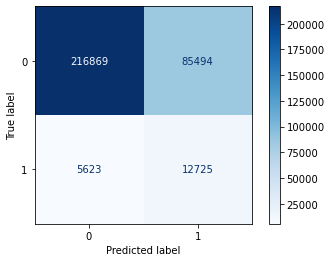

f1 : 0.2183
f3 : 0.4832
f5 : 0.5941
recall : 0.6935
negative predictive value : 0.9747
precision : 0.1296
roc_auc : 0.7770
training time : 15.903s
prediction time : 0.045s


In [44]:
m = Modelisation(X, y, pipeline.set_params(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 3.2. GridSearchCV avec SMOTE

In [45]:
categorical_features = list(range(len(COLUMNS_QUANT), len(X.columns)))
print(categorical_features)

over = SMOTENC(categorical_features=categorical_features,
               random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

cv_params = {
    "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    "over__k_neighbors": [3, 4, 5],
    "model__C": np.logspace(-6, 2, 30),
    "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                            {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                            {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                            {0:1, 1:30}, {0:1, 1:32}] 
}

print(len(ParameterGrid(cv_params)))

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
9720


In [46]:
# SearchCV(pipeline, cv_params, data_frac=0.2, drop='first', scaling=True, sparse=True, random=True, n_iter=2500, random_state=1234, n_jobs=28)

In [47]:
dico, results = restauration_CV('SMOTENC_LR_CV_Randomized2500_9720_0.2')

model : Pipeline(steps=[('over',
                 SMOTENC(categorical_features=[13, 14, 15, 16, 17, 18, 19, 20,
                                               21, 22, 23, 24, 25, 26, 27, 28,
                                               29, 30, 31, 32, 33, 34, 35, 36,
                                               37, 38, 39, 40, 41, 42, ...],
                         random_state=1234)),
                ('model', LogisticRegression())])
model_name : SMOTENC_LR
type : RandomizedSearchCV
len_grid : 9720
n_iter : 2500
columns_quant : default
columns_cat : default
drop : first
data_frac : 0.2
n_jobs : 28
temps : 1day, 15h, 17min, 12.368s
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'over__k_neighbors': [3, 4, 5], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.8566204

Export PDF : output/model_LR/23.pdf



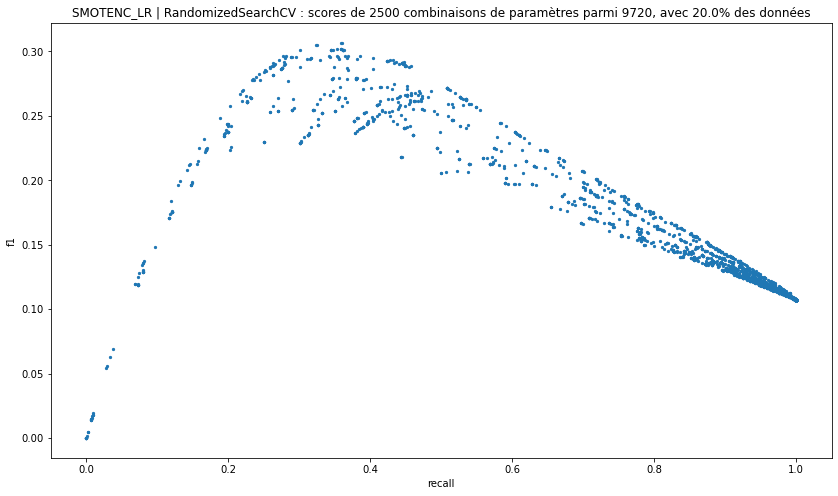

In [48]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=5, pdf=pdf)

Export PDF : output/model_LR/24.pdf



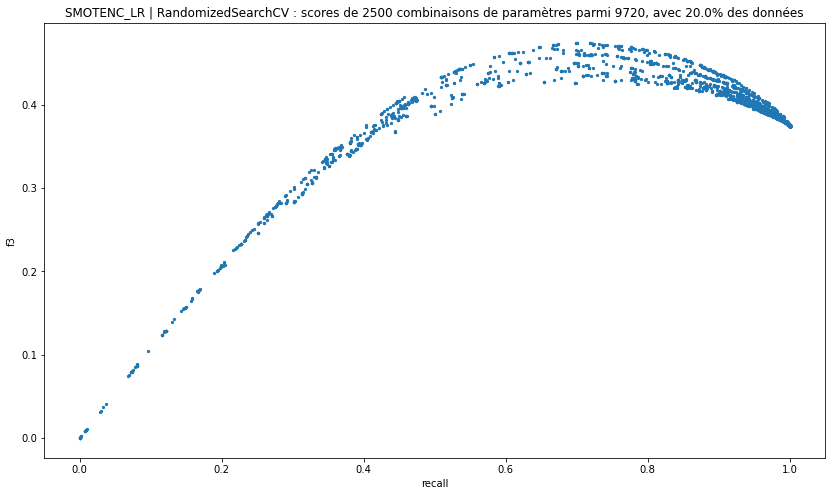

In [49]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=5, pdf=pdf)

Export PDF : output/model_LR/25.pdf



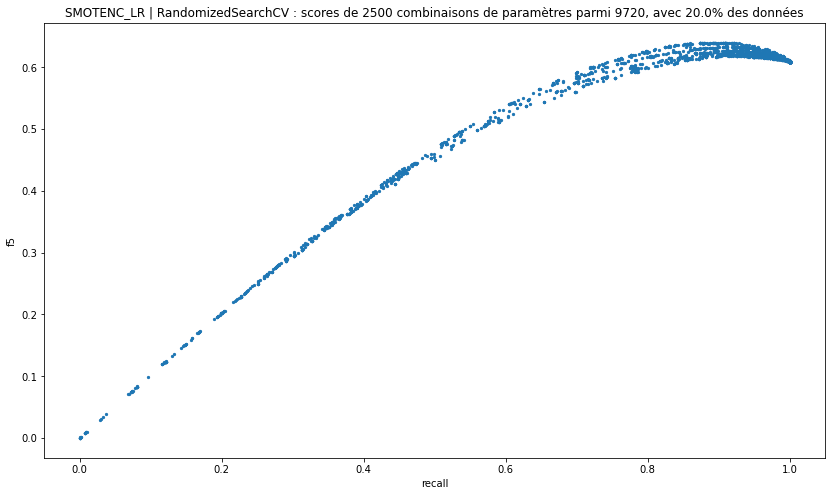

In [50]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=5, pdf=pdf)

Export PDF : output/model_LR/26.pdf



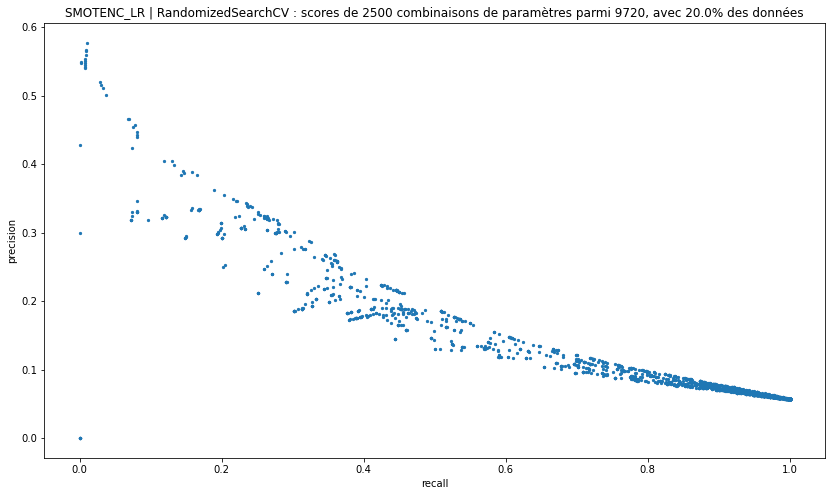

In [51]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=5, pdf=pdf)

Export PDF : output/model_LR/27.pdf



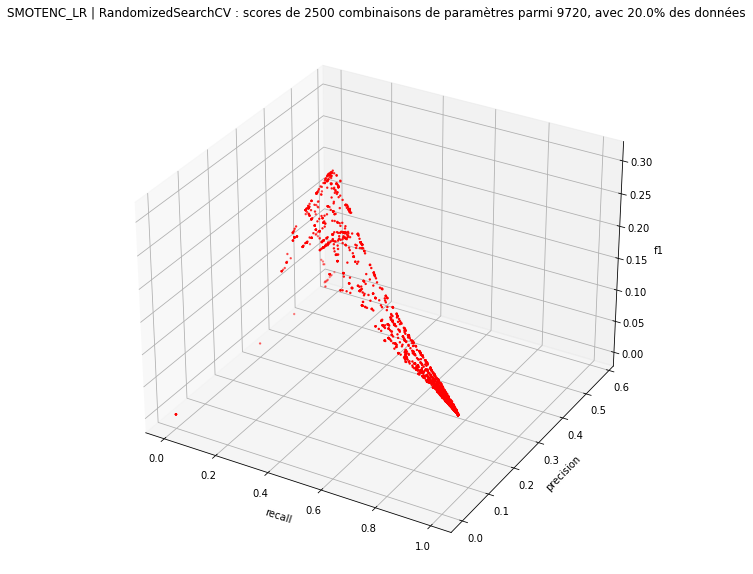

In [52]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=2, pdf=pdf)

Export PDF : output/model_LR/28.pdf



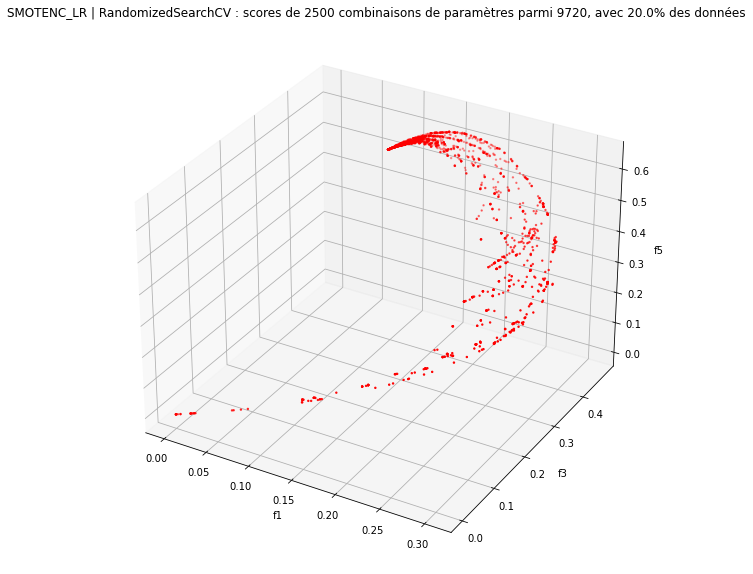

In [53]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=2, pdf=pdf)

Export PDF : output/model_LR/29.pdf



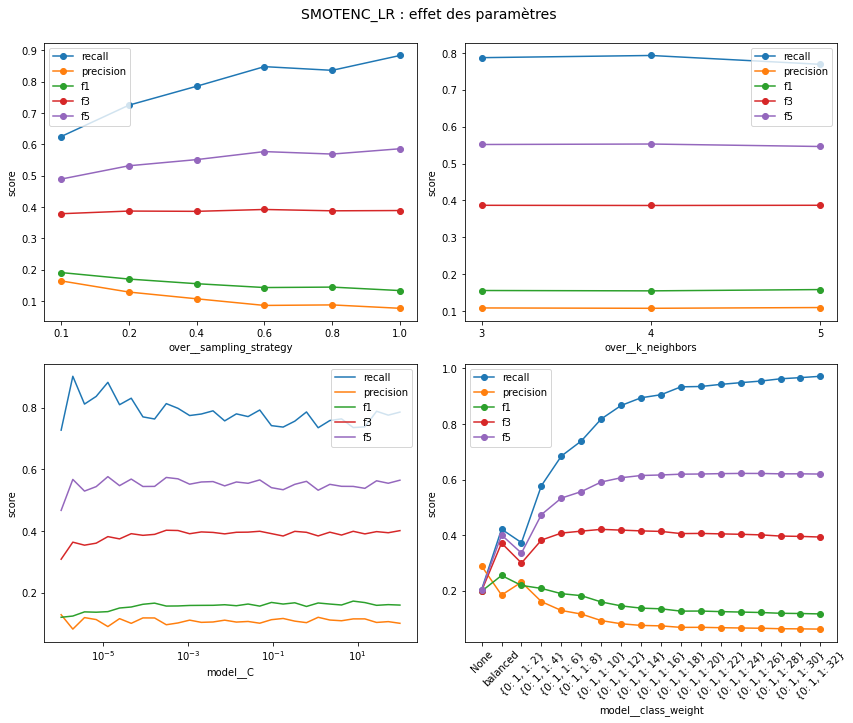

In [54]:
graph_param_CV(dico, results, xscale={'model__C': 'log'}, ncols=2, height=5, width=6, pdf=pdf)

In [55]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_over__sampling_strategy,param_over__k_neighbors,param_model__class_weight,param_model__C,params,mean_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
1782,206.159694,26.676027,0.18483,0.035742,0.1,4,"{0: 1, 1: 16}",0.329034,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.717979,...,622,0.201222,0.000604,549,0.474323,0.003832,1,0.599521,0.0068,1739
618,263.077357,13.611269,0.167833,0.017225,0.1,4,"{0: 1, 1: 16}",0.025929,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.71831,...,623,0.201106,0.000624,550,0.474309,0.003899,2,0.599655,0.006878,1738
2335,241.001076,9.891125,0.140506,0.03169,0.1,4,"{0: 1, 1: 16}",0.007279,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.719192,...,624,0.200765,0.000752,551,0.474235,0.004067,3,0.599987,0.007089,1736
1936,248.929377,14.978824,0.180969,0.02593,0.1,5,"{0: 1, 1: 16}",0.013738,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.700226,...,603,0.206912,0.001255,536,0.474113,0.005464,4,0.591685,0.008712,1781
1790,220.720592,25.706037,0.14141,0.023248,0.1,4,"{0: 1, 1: 16}",0.003857,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.719909,...,625,0.200326,0.000827,552,0.473994,0.004193,5,0.600145,0.00722,1735
688,232.904857,12.648985,0.159201,0.024449,0.1,5,"{0: 1, 1: 16}",0.007279,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.700832,...,605,0.206586,0.001241,538,0.473992,0.005555,6,0.591878,0.00888,1780
792,230.316741,10.597936,0.164384,0.035019,0.1,5,"{0: 1, 1: 16}",0.329034,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.698957,...,602,0.207103,0.001227,534,0.473849,0.00532,7,0.590969,0.008501,1783
1312,213.985697,23.090523,0.156981,0.028779,0.1,5,"{0: 1, 1: 16}",28.072162,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.698902,...,601,0.207116,0.00122,533,0.473841,0.00535,8,0.59094,0.008551,1784
2414,260.780933,7.32205,0.138301,0.035562,0.1,3,"{0: 1, 1: 16}",52.983169,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.722556,...,628,0.198839,0.000678,555,0.473243,0.003904,9,0.600813,0.006466,1726
1003,249.614407,6.932804,0.185676,0.020721,0.1,3,"{0: 1, 1: 16}",14.873521,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.722556,...,628,0.198839,0.000678,555,0.473243,0.003904,9,0.600813,0.006466,1726


Meilleure combinaison de paramètres pour f3 :


{'over__sampling_strategy': 0.1,
 'over__k_neighbors': 4,
 'model__class_weight': {0: 1, 1: 16},
 'model__C': 0.3290344562312671}

In [56]:
best_params['over__n_jobs'] = -1
PARAMS[dico['model_name']] = best_params

Export PDF : output/model_LR/30.pdf



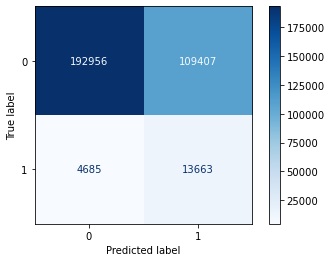

f1 : 0.1932
f3 : 0.4741
f5 : 0.6106
recall : 0.7447
negative predictive value : 0.9763
precision : 0.1110
roc_auc : 0.7682
training time : 26min, 31.403s
prediction time : 0.034s


In [57]:
m = Modelisation(X, y, pipeline.set_params(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 3.3. Comparaison

In [58]:
dr1 = restauration_CV('LR_CV_Grid_540_1', verbose=False)
dr2 = restauration_CV('RandomOver_LR_CV_Grid_3240_1', verbose=False)
dr3 = restauration_CV('SMOTENC_LR_CV_Randomized2500_9720_0.2', verbose=False)

Export PDF : output/model_LR/31.pdf



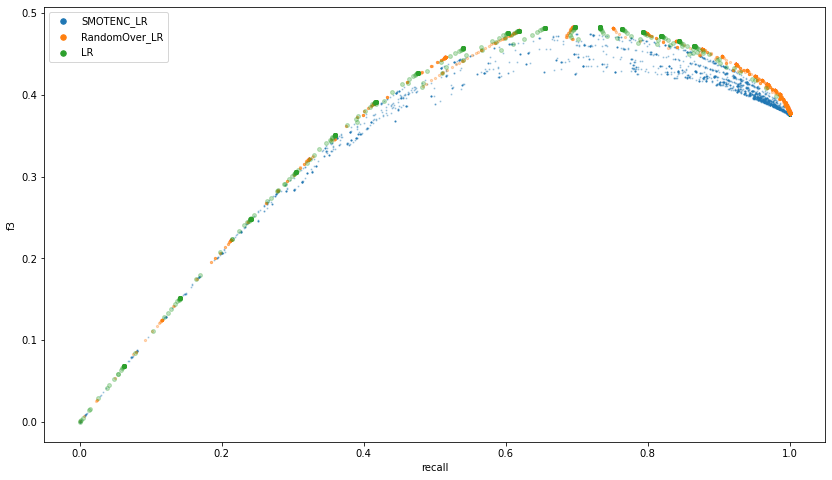

In [59]:
graph_2scores_CV_comp([dr3, dr2, dr1], 'recall', 'f3', s=[1, 5, 15], alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/32.pdf



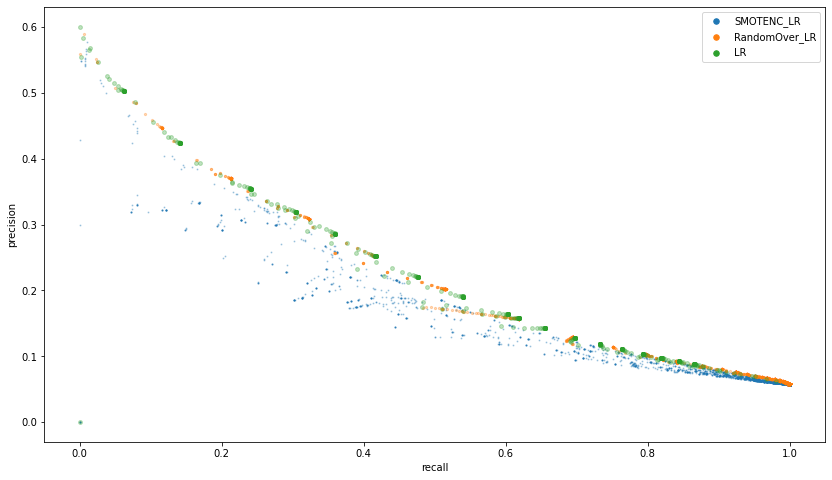

In [60]:
graph_2scores_CV_comp([dr3, dr2, dr1], 'recall', 'precision', s=[1, 5, 15], alpha=0.3, pdf=pdf)

## 4. Régression logistique avec RFECV

### 4.1. Sans oversampling

In [61]:
with open("backups/RFECV_LR.json", 'r') as f:
    export = json.load(f)
    columns_quant_RFECV = export['columns_quant']
    columns_cat_RFECV = export['columns_cat']

In [62]:
model = LogisticRegression()

cv_params = {
    "C": np.logspace(-6, 2, 30),
    "class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                     {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                     {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                     {0:1, 1:30}, {0:1, 1:32}] 
}

print(len(ParameterGrid(cv_params)))

540


In [63]:
# SearchCV(model, cv_params, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV, data_frac=1, drop='first', scaling=False, sparse=True, n_jobs=28, name='RFECV')

In [64]:
dico, results = restauration_CV('LR_RFECV_CV_Grid_540_1')

model : LogisticRegression()
model_name : LR_RFECV
type : GridSearchCV
len_grid : 540
columns_quant : ['campaignctrlast24h', 'display_size', 'nbdayssincelastclick', 'nbdisplay_1hour', 'zonecostineuro']
columns_cat : ['campaignscenario_13', 'device_type_Desktop', 'device_type_iPhone', 'display_env_app_ios', 'is_interstitial_True', 'target_env_2']
drop : first
data_frac : 1
n_jobs : 28
temps : 29min, 57.116s
params : {'C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'class_weight': [None, 'balanced', {0

In [65]:
best_params = best_score_CV(dico, results, 'f3', display_table=False)

Meilleure combinaison de paramètres pour f3 :


{'C': 7.880462815669905, 'class_weight': {0: 1, 1: 20}}

In [66]:
PARAMS[dico['model_name']] = best_params

In [67]:
datasets_df_RFECV = datasets(df, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV, drop='first')
X_RFECV = datasets_df_RFECV['X_only_quant_scaled']

Columns_quant : ['campaignctrlast24h', 'display_size', 'nbdayssincelastclick', 'nbdisplay_1hour', 'zonecostineuro']
Columns_cat : ['campaignscenario_13', 'device_type_Desktop', 'device_type_iPhone', 'display_env_app_ios', 'is_interstitial_True', 'target_env_2']
drop : first

Nombre de variables pour X_quant : 5



Index(['campaignctrlast24h', 'display_size', 'nbdayssincelastclick',
       'nbdisplay_1hour', 'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 6



Index(['campaignscenario_13', 'device_type_Desktop', 'device_type_iPhone',
       'display_env_app_ios', 'is_interstitial_True', 'target_env_2'],
      dtype='object')


Nombre de variables pour X : 11


Export PDF : output/model_LR/33.pdf



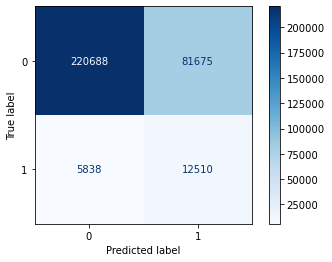

f1 : 0.2223
f3 : 0.4824
f5 : 0.5883
recall : 0.6818
negative predictive value : 0.9742
precision : 0.1328
roc_auc : 0.7731
training time : 1.964s
prediction time : 0.009s


In [68]:
m = Modelisation(X_RFECV, y, LogisticRegression(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 4.2. Avec oversampling

In [69]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

cv_params = {
        "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        "model__C": np.logspace(-6, 2, 30),
        "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                                 {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                                 {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                                 {0:1, 1:30}, {0:1, 1:32}]
        }

print(len(ParameterGrid(cv_params)))

3240


In [70]:
# SearchCV(pipeline, cv_params, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV, data_frac=1, drop='first', scaling=False, sparse=True, n_jobs=28, name='RFECV')

In [71]:
dico, results = restauration_CV('RandomOver_LR_RFECV_CV_Grid_3240_1')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', LogisticRegression())])
model_name : RandomOver_LR_RFECV
type : GridSearchCV
len_grid : 3240
columns_quant : ['campaignctrlast24h', 'display_size', 'nbdayssincelastclick', 'nbdisplay_1hour', 'zonecostineuro']
columns_cat : ['campaignscenario_13', 'device_type_Desktop', 'device_type_iPhone', 'display_env_app_ios', 'is_interstitial_True', 'target_env_2']
drop : first
data_frac : 1
n_jobs : 28
temps : 5h, 40min, 55.454s
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.172102

In [72]:
best_params = best_score_CV(dico, results, 'f3', display_table=False)

Meilleure combinaison de paramètres pour f3 :


{'model__C': 0.0020433597178569417,
 'model__class_weight': {0: 1, 1: 2},
 'over__sampling_strategy': 0.6}

In [73]:
PARAMS[dico['model_name']] = best_params
with open("backups/PARAMS_LR.json", 'w') as f:
    json.dump(PARAMS, f, indent=2)

Export PDF : output/model_LR/34.pdf



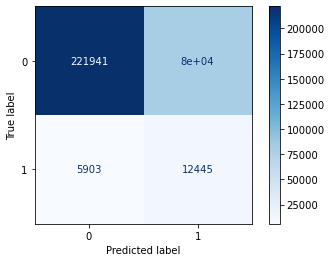

f1 : 0.2238
f3 : 0.4824
f5 : 0.5866
recall : 0.6783
negative predictive value : 0.9741
precision : 0.1340
roc_auc : 0.7729
training time : 3.978s
prediction time : 0.011s


In [74]:
m = Modelisation(X_RFECV, y, pipeline.set_params(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 4.3. Comparaison

In [75]:
dr1 = restauration_CV('LR_CV_Grid_540_1', verbose=False)
dr2 = restauration_CV('LR_RFECV_CV_Grid_540_1', verbose=False)
dr3 = restauration_CV('RandomOver_LR_CV_Grid_3240_1', verbose=False)
dr4 = restauration_CV('RandomOver_LR_RFECV_CV_Grid_3240_1', verbose=False)

Export PDF : output/model_LR/35.pdf



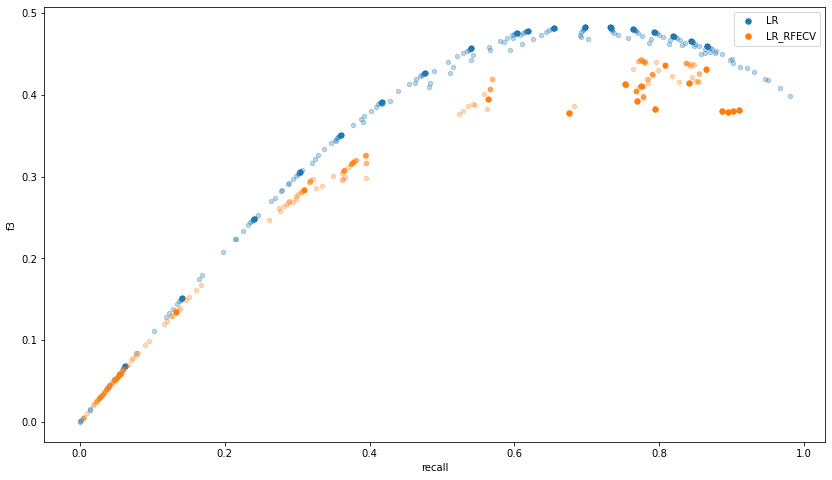

In [76]:
graph_2scores_CV_comp([dr1, dr2], 'recall', 'f3', alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/36.pdf



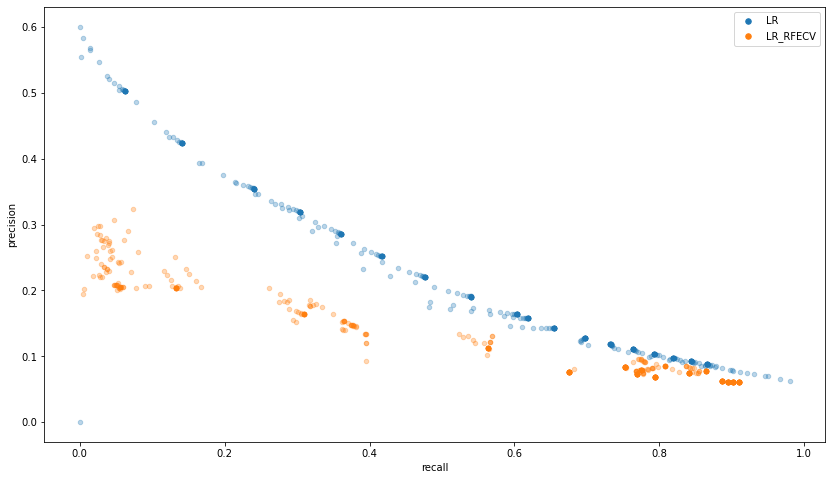

In [77]:
graph_2scores_CV_comp([dr1, dr2], 'recall', 'precision', alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/37.pdf



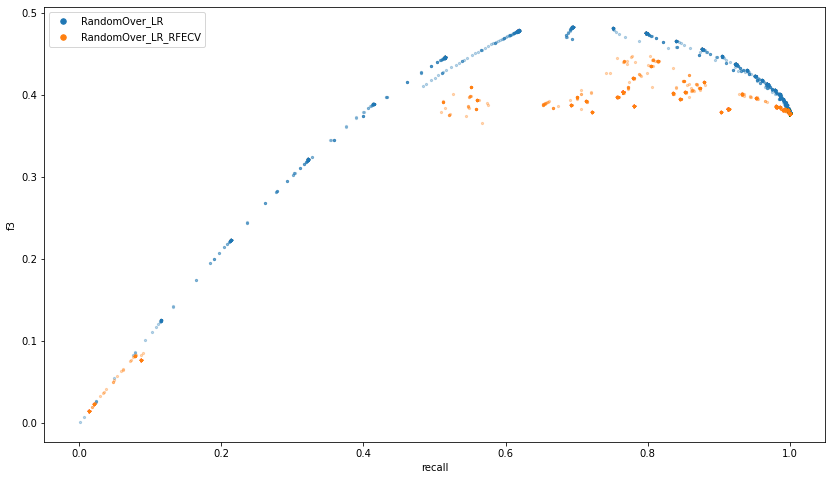

In [78]:
graph_2scores_CV_comp([dr3, dr4], 'recall', 'f3', s=[5, 5], alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/38.pdf



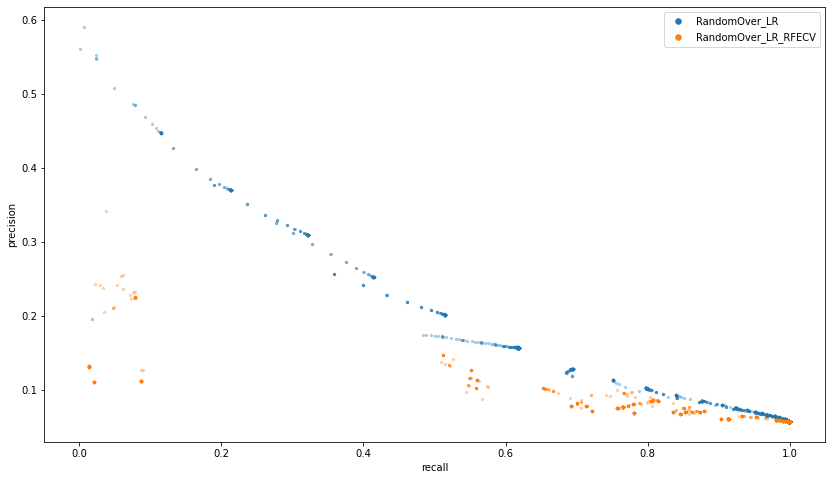

In [79]:
graph_2scores_CV_comp([dr3, dr4], 'recall', 'precision', s=[5, 5], alpha=0.3, pdf=pdf)

## 5. Bilan

In [80]:
scores_df = pd.DataFrame(SCORES).set_index('model_name')
a = scores_df.columns.tolist()
a.remove('training_time')
a.remove('prediction_time')
scores_df.sort_values(by='f3', ascending=False).style.background_gradient(cmap='Blues', subset=a).background_gradient(cmap='Blues_r', subset=['training_time', 'prediction_time'])

,f1,f3,f5,recall,negative predictive value,precision,roc_auc,training_time,prediction_time
model_name,,,,,,,,,
RandomOver_LR,0.218329,0.483195,0.594072,0.693536,0.974727,0.129557,0.776983,15.902857,0.045133
LR,0.217223,0.482845,0.594728,0.695444,0.974781,0.128713,0.777285,9.921240,0.065444
LR_RFECV,0.222335,0.482421,0.588296,0.681818,0.974228,0.132824,0.773069,1.963696,0.009016
RandomOver_LR_RFECV,0.223801,0.482366,0.586638,0.678276,0.974092,0.134009,0.772931,3.977919,0.010504
SMOTENC_LR,0.193229,0.474077,0.610616,0.744659,0.976295,0.111018,0.768182,1591.403222,0.033975


In [81]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:30:40
